In [1]:
from astropy.io import fits #astropy modules for FITS IO
import numpy as np #numpy gives us better array management 
from scipy import interpolate #spline interpolation
import os #checking status of requested files

In [2]:
import matplotlib  #ploting
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import spgen as spgen #Python Routines for SpecGen Routines

In [5]:
# For Debuging
import importlib

In [68]:
importlib.reload(spgen) 

<module 'spgen' from '/home/rowe/Documents/jwst/jwst-mtl/SOSS/specgen/spgen.py'>

## Notebook Parameters  
These parameters set up the work environment.

In [7]:
workdir='/data/JWST/' #root folder for local files

## Model Parameters

In [41]:
pars=spgen.ModelPars()              #Set up default parameters
filename=workdir+'simpars.txt'      #location of file for parameter import 
pars=spgen.read_pars(filename,pars) #read in parameter file

Not found:  rprstype1 9 rprstype 1
Linenumber:  42


## Get Instrument Response 

In [73]:
response_file=workdir+'tables/NIRISS_Throughput_STScI.fits'
response_ld,response_n0,response_n1,response_n2,response_n3,quantum_yield=spgen.readresponse(response_file)

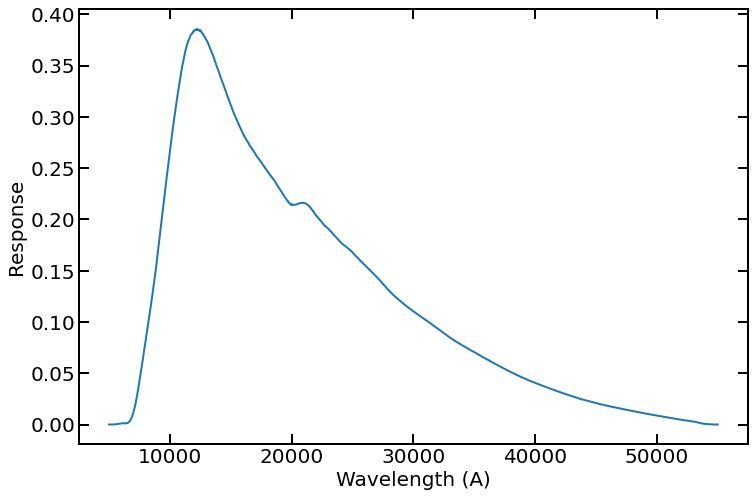

In [74]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(response_ld,response_n1,lw=2)

ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Response')

plt.show()

## Read in Stellar Atmosphere

In [69]:
starmodel_wv,starmodel_flux=spgen.readstarmodel(workdir+pars.modelfile,pars.nmodeltype)

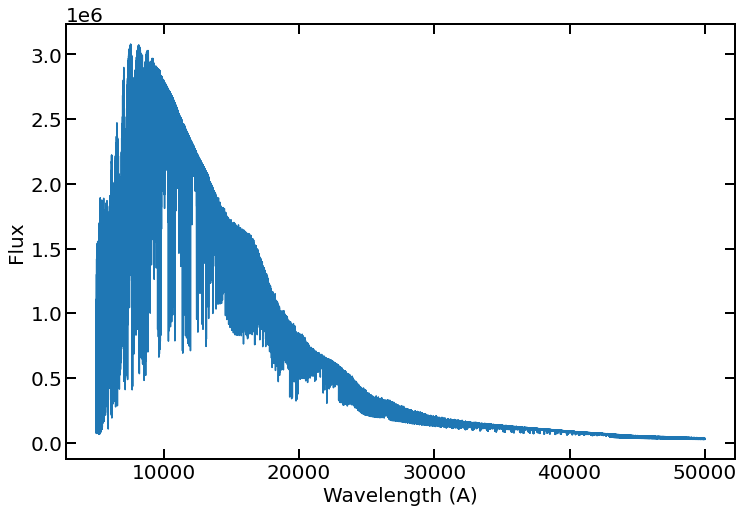

In [70]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(starmodel_wv,starmodel_flux)

ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux')

plt.show()

## Read in Planet atmosphere

In [45]:
pmodeltype=2  ## Needs to be added as model parameter.  
planetmodel_wv,planetmodel_depth=spgen.readplanetmodel(workdir+pars.pmodelfile[0],pmodeltype)

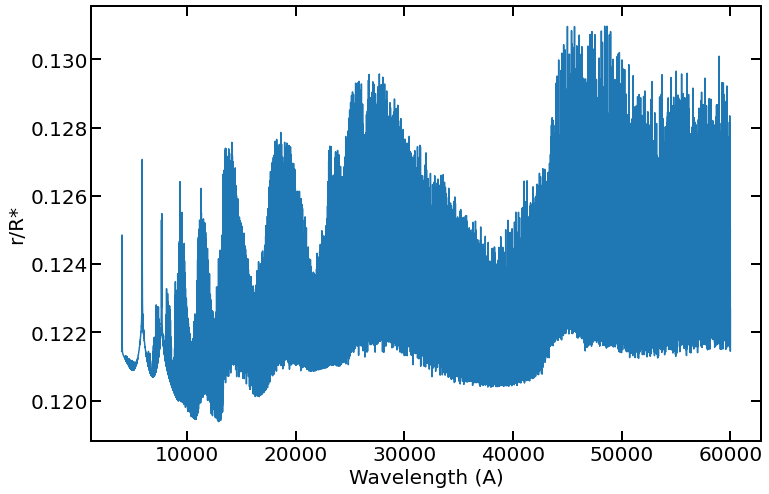

In [67]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(planetmodel_wv,planetmodel_depth)

ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('r/R*')

plt.show()

In [52]:
print(spgen.p2w.__doc__)

Usage: w=p2w(p,noversample,ntrace) Converts x-pixel (p) to wavelength (w)
    Inputs:
      p : pixel value along dispersion axis (float) on oversampled grid.
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      w : wavelength (A)
    


In [53]:
print(spgen.w2p.__doc__)

Usage: p=w2p(w,noversample,ntrace) Converts wavelength (w) to x-pixel (p)
    Inputs:
      w : wavelength (A)
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      p : pixel value along dispersion axis (float) on oversampled grid.

    


In [55]:
print(spgen.ptrace.__doc__)

given x-pixel, return y-position based on trace
    Usage:
    py = ptrace(px,noversample,ntrace)

    Inputs:
      px : pixel on dispersion axis (float) on oversampled grid.
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      py : pixel on spatial axis (float) on oversampled grid.
    


## Generate unconvolved image with n=1 order

In [103]:
#array to hold synthetic image
xmax=pars.xout*pars.noversample
ymax=pars.yout*pars.noversample

pixels=np.zeros((xmax,ymax))

norder=1 #Order to use.

response_spl = interpolate.splrep(response_ld, response_n1, s=0)
quantum_yield_spl  = interpolate.splrep(response_ld, quantum_yield, s=0)
rmax=np.max(response_ld)
rmin=np.min(response_ld)


for k in range(starmodel_wv.shape[0]):
    
    w=starmodel_wv[k]
    i=spgen.w2p(w,pars.noversample,norder)
    j=spgen.ptrace(i,pars.noversample,norder)
    
    if (i<=xmax+1) & (i>=0) & (j<=ymax+1) & (j>=0): #check if pixel is on grid
        
        if w < rmax and w > rmin:
            response_one = interpolate.splev(w, response_spl, der=0)
            quantum_yield_one = interpolate.splev(w, quantum_yield_spl, der=0)
        else:
            response_one = 0
            quantum_yield_one = 0
        flux=starmodel_flux[k]*response_one*quantum_yield_one
        pixels=addflux2pix(i,j,pixels,flux)


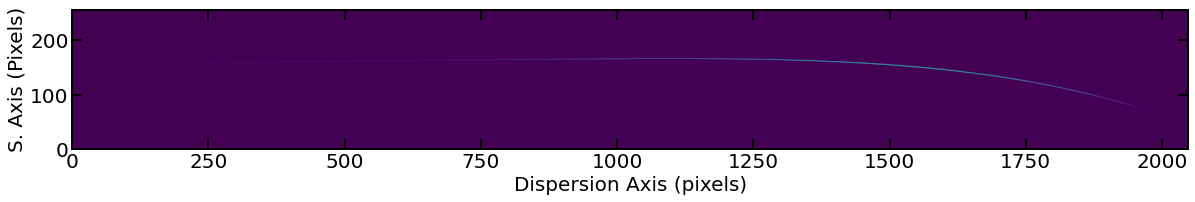

In [109]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(20,4)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.imshow(np.transpose(pixels))
ax.axis((0,pixels.shape[0],0,pixels.shape[1]))

ax.set_xlabel('Dispersion Axis (pixels)')
ax.set_ylabel('S. Axis (Pixels)')
plt.show()

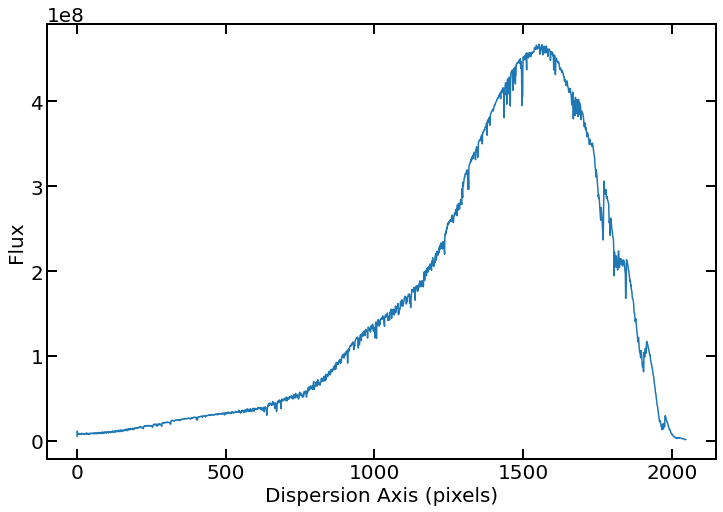

In [112]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(np.sum(pixels,axis=1),label='Column Sum') #Plot the sum of each column

ax.set_xlabel('Dispersion Axis (pixels)')
ax.set_ylabel('Flux')

plt.show()